# Out-of-Sample Forecast

**Difficult**:  

After reviewing the exercises of chapters 4 and 5, I realized that it's entirely based on `in-sample testing`.  So the MA and AR models provide fitted lines instead of true forecasts for the test / forecast horizon.

Here, I want to explore the creation of a true `out-of-sample` forecast.  The data points from the test set are only used for evaluation / calculating the MSE.  

Use ARIMA's or SARIMAX's `predict` or `forecast` method to accomplish that.  Note that ARMA will fairly quickly converge to the long-run mean.  See stackexchange in footnote.    

sources: 
* [machinelearningmastery.com](https://machinelearningmastery.com/make-sample-forecasts-arima-python/)
* [datastud.dev](https://datastud.dev/posts/python-arima-how-to)
* [stats.stackexchange.com](https://stats.stackexchange.com/questions/76160/im-not-sure-that-statsmodels-is-predicting-out-of-sample)
* [setscholars.net](https://setscholars.net/machine-learning-for-beginners-a-guide-to-out-of-sample-forecasts-with-arima-in-python/)

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# omd
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt

importlib.reload(tt)

<module 'timetools' from '../../My-Code/timetools.py'>

In [3]:
# simulation of stationary AR(2) process

np.random.seed(42)

ma = np.array([1, 0, 0])
ar = np.array([1, -0.33, -0.50])

ar2 = ArmaProcess(ar=ar, ma=ma).generate_sample(nsample=1000)

Test Statistic                -7.566606e+00
p-value                        2.914516e-11
#Lags Used                     1.000000e+00
Number of Observations Used    9.980000e+02
Critical Value (1%)           -3.436919e+00
Critical Value (5%)           -2.864440e+00
Critical Value (10%)          -2.568314e+00
dtype: float64

The time series is stationary.


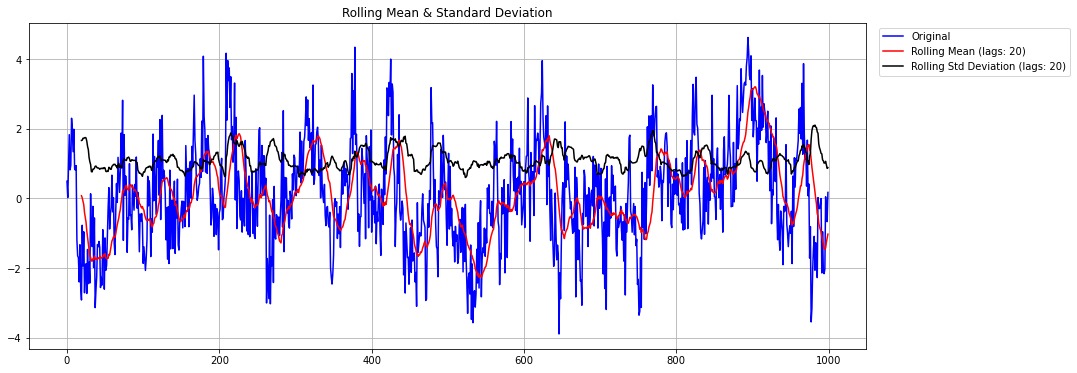

In [4]:
# Plot your simulated autoregressive process.
# Run the ADF test and check if the process is stationary. If not, apply differencing.
tt.adf(pd.Series(ar2))
tt.plot_for_stationary(pd.Series(ar2))

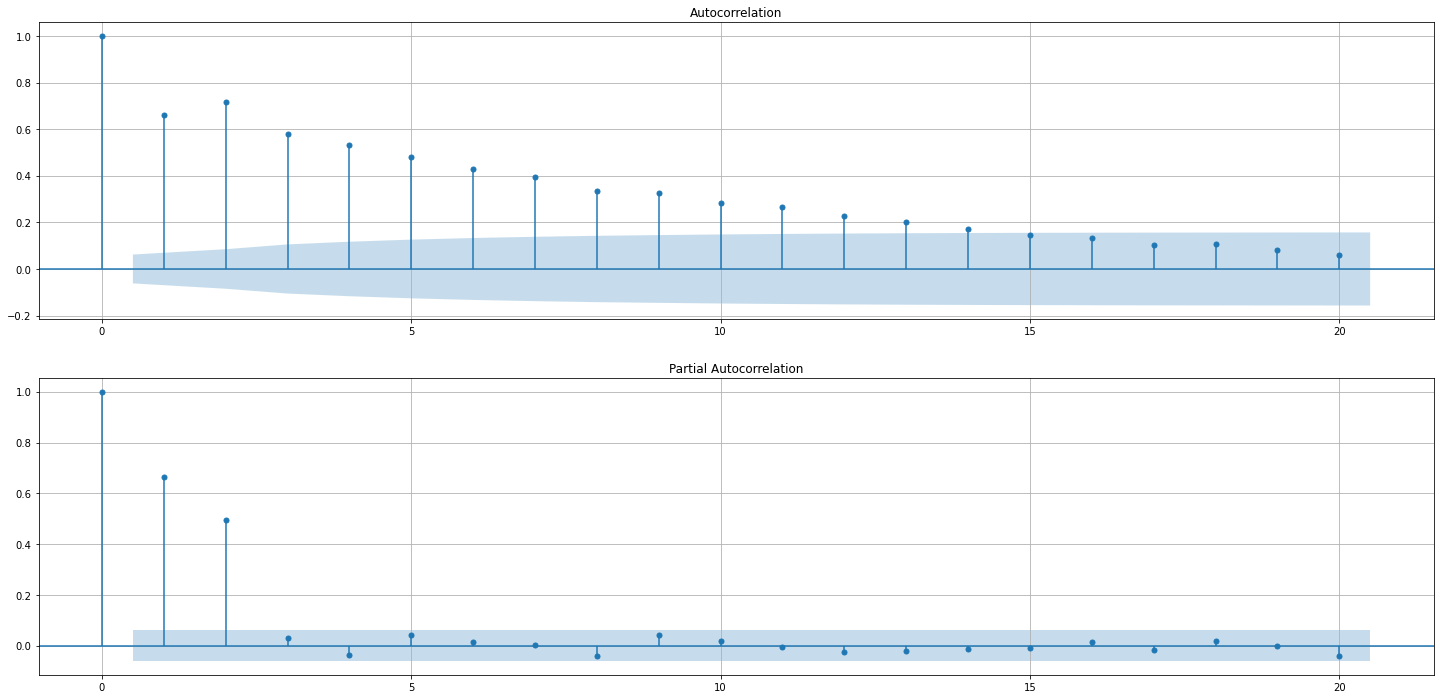

In [5]:
# Plot the ACF. Is it slowly decaying?
# Plot the PACF. Are there significant coefficients after lag 2?

tt.plot_acf_pcf(pd.Series(ar2), num_lag=20)

Yes, the ACF plot is slowly decaying and the PACF plot shows insignificant coefficients.  Hence, it's an autoregressive process.

In [6]:
# Separate your simulated series into a training and test set. Take the first 800
# timesteps for the training set and assign the rest to the test set.

df = pd.DataFrame(ar2, columns=['value'])
train, test = df[:-200], df[-200:]

In [7]:
print(df.shape[0])
print(len(train))
print(len(test))

1000
800
200


In [8]:
test

,value
800,1.153388
801,0.095529
802,0.704340
803,-0.182079
804,-0.142412
...,...
995,-2.027377
996,0.048371
997,-0.356883
998,-0.664765


In [9]:
# Forecast the next 200 time steps, which is the equivalent of the test set length.

X = df['value'].values
size = int(len(X) * 0.8)

# split into train and test sets
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(3,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [10]:
print('history length: {}'.format(len(history)))
history[-2:]

history length: 1000


[-0.6647651754763972, 0.17476867188214262]

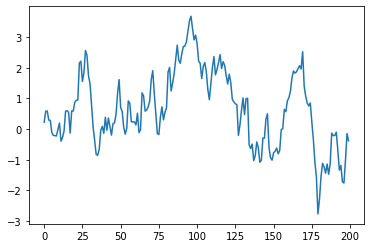

In [11]:
plt.plot(predictions)

In [13]:
# Forecast the next 200 time steps, which is the equivalent of the test set length.

from statsmodels.tsa.arima_model import ARIMA

X = df['value'].values
size = int(len(X) * 0.8)

# split into train and test sets
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions2 = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(3,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions2.append(yhat)
    obs = test[t]
    history.append(obs)

In [30]:
comparison = pd.DataFrame()
comparison['SARIMAX'] = predictions
comparison['ARIMA'] = predictions2
comparison['Difference'] = comparison['SARIMAX'] - comparison['ARIMA']
comparison

,SARIMAX,ARIMA,Difference
0,0.221317,[0.21281711299687991],[0.008499515608109492]
1,0.576915,[0.5696000687547411],[0.0073147944389334585]
2,0.587501,[0.5795564751270155],[0.007944719615173068]
3,0.291902,[0.2841054597636352],[0.007796770139724241]
4,0.280298,[0.27202322584159117],[0.008274870520425026]
...,...,...,...
195,-1.724205,[-1.7053366299436272],[-0.01886794024444005]
196,-1.759452,[-1.7405936391138004],[-0.018858523584307063]
197,-1.024469,[-1.0040455025912722],[-0.0204236014555379]
198,-0.146619,[-0.12637077773758296],[-0.020248076307220114]


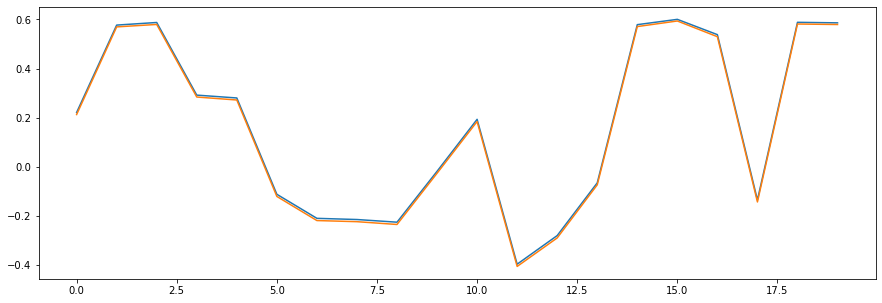

In [28]:
# SARIMAX and ARIMA models provided the same results
# Hence, SARIMAX with seasonal term and exogenous time series is the same as ARIMA
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(predictions[:20])
plt.plot(predictions2[:20])

Make forecasts over the test set. Use the historical mean method, last value method, and an AR(2) model. Use the `recursive_forecast` function and use a `window` length of 2.

In [118]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [122]:
pred_df = test.copy()
train, test = df[:-200], df[-200:]
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_AR'] = pred_AR

pred_df.head()

,value,pred_mean,pred_last_value,pred_AR
800,1.153388,-0.049737,0.461912,0.221317
801,0.095529,-0.049737,0.461912,0.290105
802,0.704340,-0.048056,0.095529,0.587501
803,-0.182079,-0.048056,0.095529,0.256042
804,-0.142412,-0.047287,-0.182079,0.280298


In [125]:
pred_df['pred_oos'] = predictions
pred_df.head()

,value,pred_mean,pred_last_value,pred_AR,oos_pred,pred_oos
800,1.153388,-0.049737,0.461912,0.221317,0.221317,0.221317
801,0.095529,-0.049737,0.461912,0.290105,0.576915,0.576915
802,0.704340,-0.048056,0.095529,0.587501,0.587501,0.587501
803,-0.182079,-0.048056,0.095529,0.256042,0.291902,0.291902
804,-0.142412,-0.047287,-0.182079,0.280298,0.280298,0.280298


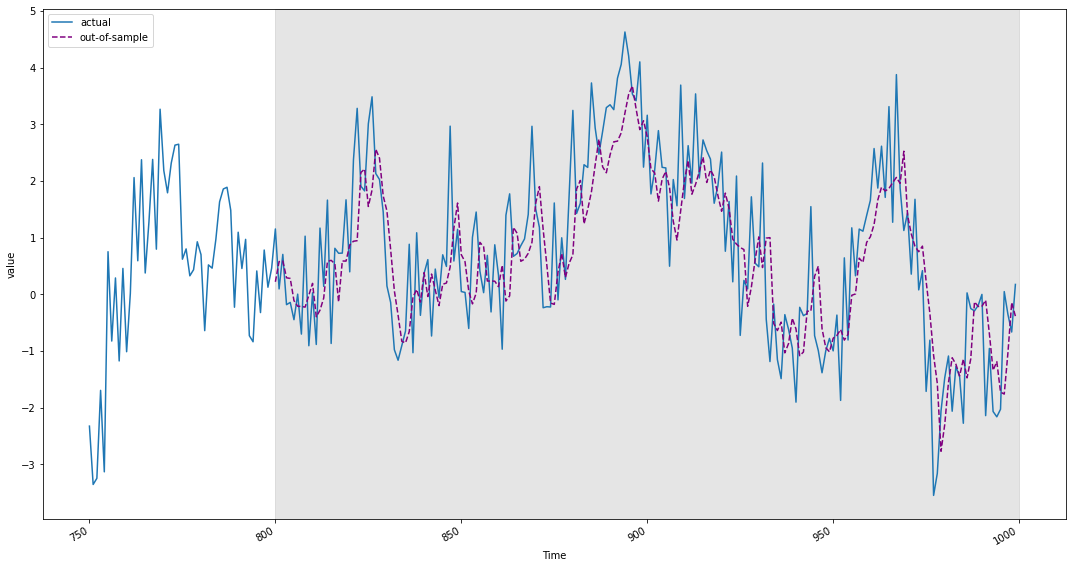

In [129]:
# Plot your forecasts

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df[750:]['value'], label='actual')
# ax.plot(pred_df.pred_mean, 'g:', label='mean')
# ax.plot(pred_df.pred_last_value, 'r-.', label='last')
# ax.plot(pred_df.pred_AR, 'k--', label='AR(3)')
ax.plot(pred_df.pred_oos, ls='--', color='purple', label='out-of-sample')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('value')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

In [127]:
# Measure the MSE and identify your champion model

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['value'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['value'], pred_df['pred_last_value'])
mse_AR = mean_squared_error(pred_df['value'], pred_df['pred_AR'])
mse_OOS = mean_squared_error(pred_df['value'], pred_df['pred_oos'])

print(mse_mean, mse_last, mse_AR, mse_OOS)

3.0882016808214443 1.2111519051869672 0.9691013344906326 0.9323500289831368


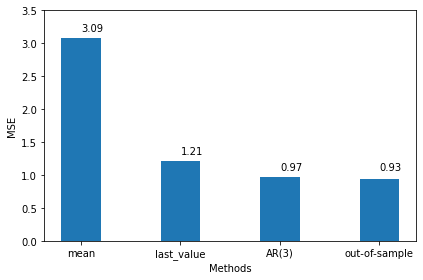

In [128]:
# Plot your MSEs in a bar plot

fig, ax = plt.subplots()

ax.bar(
    ['mean', 'last_value', 'AR(3)', 'out-of-sample'], 
    [mse_mean, mse_last, mse_AR, mse_OOS], 
    width=0.4)

ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 3.5)

ax.text(y=mse_mean+0.1, x=0, s=round(mse_mean, 2))
ax.text(y=mse_last+0.1, x=1, s=round(mse_last, 2))
ax.text(y=mse_AR+0.1, x=2, s=round(mse_AR, 2))
ax.text(y=mse_AR+0.1, x=3, s=round(mse_OOS, 2))

plt.tight_layout()

Working through the forecasting examples of chapter 4 and 5, I was wondering if it would be possible to also include examples where the forecast  does not include data from the test set.  I was thinking of recursively including forecasted data points.  The test set would only be used for calculating the MSE.  Wouldn't this be a true out-of-sample forecast?

In this example, the history set is the same as the train set for the first iteration of the loop.  With every iteration, a forecasted data point is added to the history set which is used for the next forecast:  
```python
X = df['value'].values
size = int(len(X) * 0.8)

# split into train and test sets
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(3,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    output[0]
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
```

In [41]:
# res.plot_predict(720, 840)

X = df['value'].values
size = int(len(X) * 0.8)

# split into train and test sets
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

model = SARIMAX(history, order=(3,0,0))
model_fit = model.fit(disp=0)

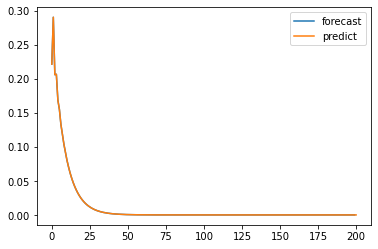

In [47]:
plt.plot(model_fit.forecast(200), label='forecast')
plt.plot(model_fit.predict(start=800, end=1000), label='predict')
plt.legend()
plt.show()

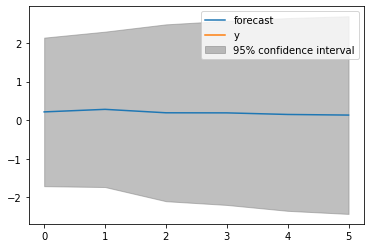

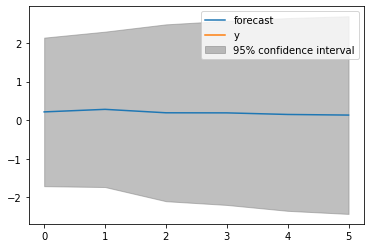

In [39]:
model_fit.plot_predict(800, 805)